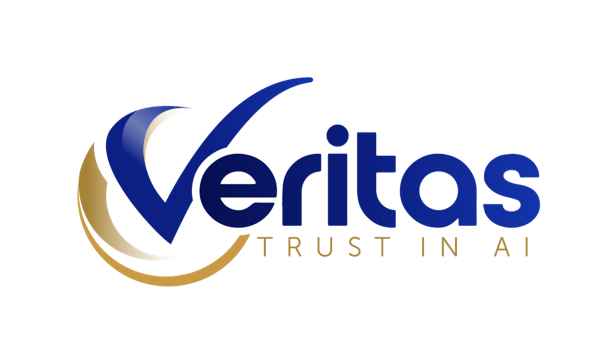

# Veritas Diagnosis Tool Demo : Propensity Model 
    
<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a propensity model and use diagnosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness & transparency assessment report.
</p>    
<p>    
    Propensity Model is a multi-class classification model. <br/>
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Fairness & Transparency Diagnosis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 compute performance and fairness metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 compute trade off analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3 compute feature importance analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4 compute transparency analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.5 save results in json artifact <br/>
</p>

# 1. Loading Data and Model

## Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path
# making veritas available in search path
sys.path.append('../../')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
import os
sys.path.insert(0, os.getcwd().split('veritastool\\examples')[0])
import sys
%load_ext autoreload
%autoreload 2

## Loading Data 

In [2]:
sys.path.append('./customer_marketing_example/')
pth = ''
#Load Phase 1-Customer Marketing Uplift Model Data, Results and Related Functions
file_prop = os.path.join(pth,'data',"mktg_uplift_acq_dict.pickle")
input_prop = open(file_prop, "rb")
cm_prop = pickle.load(input_prop)

C:\AAI\env\py310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\AAI\env\py310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\AAI\env\py310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please

In [3]:
#Propensity dataset
y_true = cm_prop["y_test"]
y_train = cm_prop["y_train"]
model_obj = cm_prop['model']
model_name = "base_classification" 
model_type = "classification"
y_prob = pd.DataFrame(cm_prop["y_prob"], columns=['CN', 'CR', 'TN', 'TR'])
p_grp = {'isforeign':[0], 'isfemale':[0],'isforeign|isfemale':'maj_rest'}
x_train = cm_prop["X_train"].drop(['ID'], axis = 1)
x_test = cm_prop["X_test"].drop(['ID'], axis = 1)

## Loading Model

In [4]:
clf = cm_prop['model']

#fit the model as it's a pre-requisite for transparency analysis
clf = clf.fit(x_train, y_train)

In [5]:
y_pred = clf.predict(x_test)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,y_pred),3)))

Balanced Accuracy: 0.343


## Data Exploration

In [6]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0],x_train.shape[1]))
x_train.head()

No of rows: 80000 
No. of columns: 6


,income,noproducts,didrespond,age,isfemale,isforeign
0,21851.709120,1,0,43.478362,0,1
1,66192.533929,3,0,47.779519,0,0
2,18829.532673,3,0,34.056453,1,0
3,71774.006240,7,0,46.640052,0,1
4,45153.751310,1,0,33.722548,0,0


Multiclass Label Distribution

<Axes: >

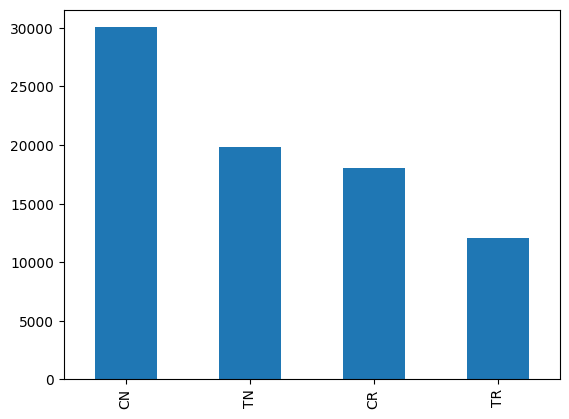

In [7]:
pd.Series(y_train).value_counts().plot.bar()

# 2. Fairness & Transparency Diagnosis

## Import Veritas Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. BaseClassification use case is showcased in this notebook.

In [8]:
from veritastool.model.modelwrapper import ModelWrapper
from veritastool.model.model_container import ModelContainer
from veritastool.usecases.base_classification import BaseClassification

## Initializing Veritas Library

In [27]:
#Create Model Container 
container = ModelContainer(y_true,  p_grp, model_type, model_name, y_pred, y_prob, y_train, \
                           x_train=x_train, x_test=x_test, model_object=None, \
                           pos_label=['TR','CR'], neg_label=['TN','CN'] ) 
                           #pos_label = None)
                           

<h5 align="center">Table 1: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |No|
| x_train     | data           | training      | train set features |-      |No|
| p_grp       | protected vars |    -          | list of privileged groups| { 'isforeign': [0] , isfemale':[0],<br/>'isforeign\|isfemale':'maj_rest' }   |Yes|
| up_grp       | protected vars |    -          | list of privileged groups|    |No|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'classification'    |Yes|
| model_name  | model          |    -          | name of model | 'propensity'   |No|
| pos_label  | target          |    -          | favourable label | ['TR', 'CR']   |No|
| neg_label  | target          |    -          | unfavourable label | ['TN', 'CN']   |No|



In [28]:
#Create Use Case Object
clf_obj= BaseClassification(model_params = [container], fair_threshold = 80, fair_concern = "eligible", \
                           fair_priority = "benefit", fair_impact = "normal",fair_metric_type='difference', \
                           perf_metric_name = "accuracy", tran_row_num=[12,42], tran_max_sample=1000, \
                           tran_pdp_feature = ['income','age'], tran_pdp_target='TR')                           

In [29]:
clf_obj.multiclass_flag

False

<h5 align="center">Table 2: Base Classification parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_threshold | fairness metric thresolding |threshold used for assessment|floating value between 0 and 1 (treated as actual <br/> value) or 1 and 100 (treated as p%)   |No|
| fair_concern |fair_metric selection| for auto-suggestion: most concerned cohort| "eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection| for auto-suggestion: top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection | for auto-suggestion: impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_metric_type  | fair_metric selection | for auto-suggestion: type of metric | "difference" or "ratio"  |No|
| fair_metric_name      | metric name |primary fairness metric | "auto" or any of supported ones <br/> like "expected_harm"   |No|
| perf_metric_name      | metric name |primary performance metric |"expected_profit"   |Yes|
| tran_row_num      | transparency parameter |row number for local interpretability plot starting with 1 |list of integers   |No|
| tran_max_sample      | transparency parameter |sampling size for transparency analysis |float value between 0 and 1 (treated as <br/> percentage of rows)  or  int treated as #rows   |No|
| tran_pdp_feature      | transparency parameter |feature list for pdp plots |list of features   |No|
| tran_pdp_target      | transparency parameter |class label for pdp plots(required for multi-class model) |string |No|
| tran_max_display      | transparency parameter |#features to be displayed in the transparency plots |int    |No|
| tran_processed_data      | transparency parameter |sample dataframe for the analysis incase x_train is a string |dataframe    |No|
| tran_processed_label      | transparency parameter |list of y_train(s) for the given tran_processed_data |list    |No|






## Starting Fairness diagnosis

In [32]:
clf_obj.evaluate()

Evaluate performance:   0%|          

y_true.shape: (49, 1, 10000)
idx.shape: (49, 1, 10000, 4)
y_true.shape: (1, 1, 10000)
idx.shape: (1, 1, 10000, 4)


Traceback (most recent call last):
  File "C:\AAI\env\py310\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\nisith.singh\AppData\Local\Temp\ipykernel_44996\1344677901.py", line 1, in <module>
  File "C:\AAI\MAS2_repos\to_sync\veritas-toolkit\veritastool\principles\fairness.py", line 668, in evaluate
    self._compute_performance(n_threads=n_threads, seed = seed, eval_pbar=eval_pbar)
  File "C:\AAI\MAS2_repos\to_sync\veritas-toolkit\veritastool\principles\fairness.py", line 803, in _compute_performance
    self.perf_metric_obj.execute_all_perf(n_threads=n_threads, seed = seed, eval_pbar=eval_pbar, disable=self.evaluate_disable)
  File "C:\AAI\MAS2_repos\to_sync\veritas-toolkit\veritastool\metrics\performance_metrics.py", line 218, in execute_all_perf
    PerformanceMetrics._execute_all_perf_map(self, [np.arange(n)], eval_pbar, 1)        
  File "C:\AAI\MAS2_repos\to_sync\veritas-toolkit\ve

In [ ]:
clf_obj.evaluate(visualize = True, output = True) 

In [ ]:
clf_obj.tradeoff()

<h5 align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Table 3: Use of protected variable in model</h5>

|Fairness|Performace|Suggestion|
| -------- | ---------- | --------------- |
|Worse  |Worse	|Include|
|Better|Better|Exclude|
|Worse|Better|Examine Further|
|Better|Worse|Examine Further|

In [ ]:
clf_obj.feature_importance()

In [ ]:
clf_obj.rootcause()

In [ ]:
mitigated = clf_obj.mitigate(method=['threshold'])

In [ ]:
# mitigated y_pred of p vars based on suggested thresholds
# these can be used to reinitialise the model container and rerun the fairness analysis
# the provided model has to updated to use the suggested thresholds. alternatively, the ModelWrapper can be used

y_pred_isforeign_mtgtd = mitigated['threshold'][0]
y_pred_isfemale_mtgtd = mitigated['threshold'][1]

## Starting Transparency Diagnosis

Running transparency for model 1        done      


Exact explainer: 1003it [00:17, 56.38it/s]                                                                             


     Data preparation                   done      
     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


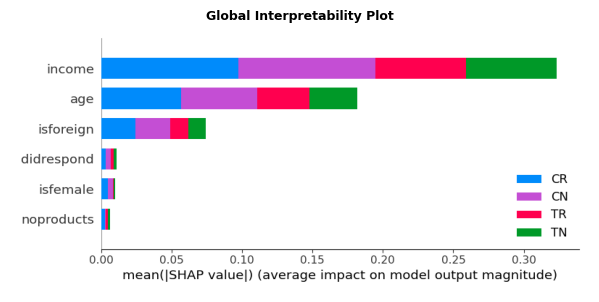

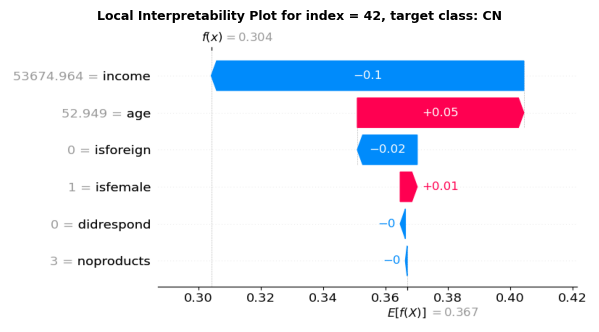

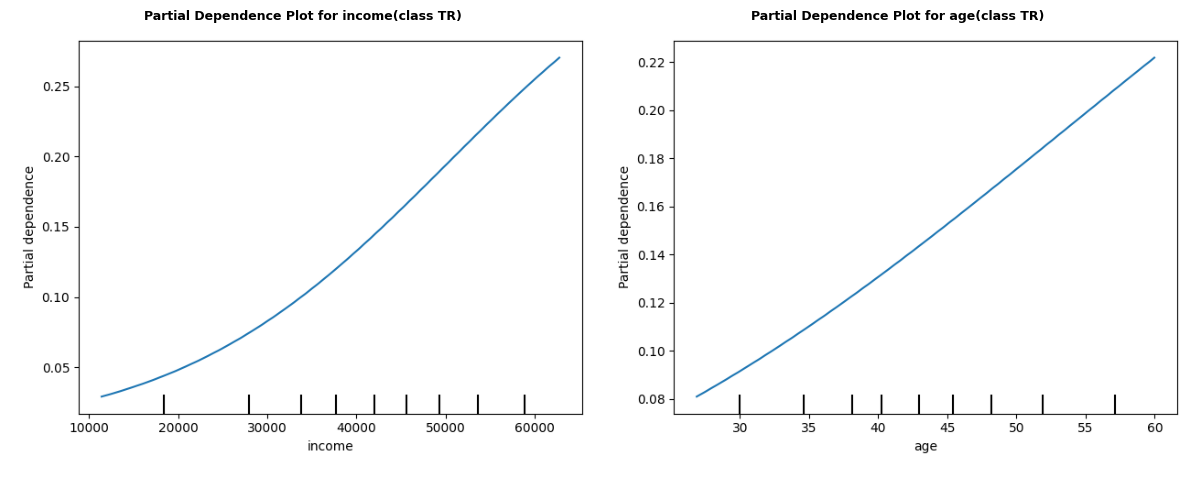

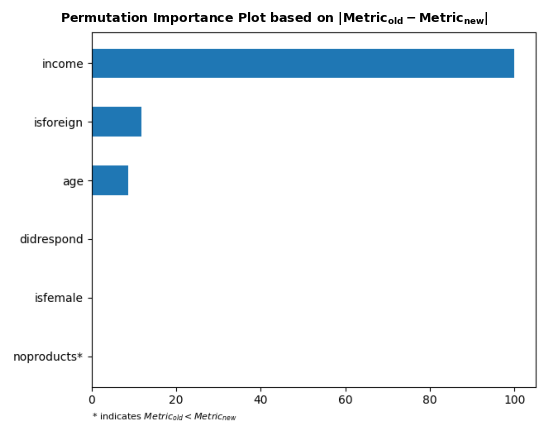

In [12]:
#run the entire transparency analysis
clf_obj.explain()

<h5 align="center">Table 3: Transparency parameters   </h5>

| Var Name    | Description   |  Value        |Default|Compulsory|
| :---        |          ---: |          ---: |---:|---:|
| disable | disable any of the transparency analysis |list of valid inputs ['interpret','partial_dep','perm_imp']  |blank list |No|
| local_row_num |row number for local interpretability plot |integer   |last value of tran_row_num |No|
| model_num   |model for which assessment is required |1 or 2   |last model in model container |No|
| output      |boolean value for displaying the plots |True or False   |True |No|





In [ ]:
#get the local interpretability plot for specific row index
clf_obj.explain(local_row_num = 12)

## Compiling Results

In [ ]:
#compile fairness and transparency diagnosis results
clf_obj.compile()